# Linear models with CNN features

In [1]:
from datetime import datetime
t0 = datetime.now()

In [2]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

Using Theano backend.


## Introduction

In [3]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [4]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Linear models in keras

It turns out that each of the Dense() layers is just a *linear model*, followed by a simple *activation function*. We'll learn about the activation function later - first, let's review how linear models work.

A linear model is (as I'm sure you know) simply a model where each row is calculated as *sum(row &#42; weights)*, where *weights* needs to be learnt from the data, and will be the same for every row. For example, let's create some data that we know is linearly related:

In [5]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

In [6]:
x[:5]

array([[ 0.2355,  0.3822],
       [ 0.6079,  0.7176],
       [ 0.4895,  0.6773],
       [ 0.6454,  0.6657],
       [ 0.5119,  0.6007]])

In [7]:
y[:5]

array([ 2.6175,  4.3685,  4.0109,  4.2878,  3.826 ])

We can use keras to create a simple linear model (*Dense()* - with no activation - in Keras) and optimize it using SGD to minimize mean squared error (*mse*):

In [8]:
lm = Sequential([ Dense(1, input_shape=(2,)) ])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

(See the *Optim Tutorial* notebook and associated Excel spreadsheet to learn all about SGD and related optimization algorithms.)

This has now learnt internal weights inside the lm model, which we can use to evaluate the loss function (MSE).

In [9]:
lm.evaluate(x, y, verbose=0)

12.501455307006836

In [10]:
lm.fit(x, y, nb_epoch=5, batch_size=1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 1.1551      
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.1277     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0436     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0184     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0079     


In [11]:
lm.evaluate(x, y, verbose=0)

0.0033903305884450674

And, of course, we can also take a look at the weights - after fitting, we should see that they are close to the weights we used to calculate y (2.0, 3.0, and 1.0).

In [12]:
lm.get_weights()

[array([[ 1.9154],
        [ 2.8492]], dtype=float32), array([ 1.1193], dtype=float32)]

## Train linear model on predictions

In [13]:
path = 'data/small_data_set/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

We will process as many images at a time as our graphics card allows. This is a case of trial and error to find the max batch size - the largest size that doesn't give an out of memory error.

In [14]:
batch_size=32
#batch_size=4

We need to start with our VGG 16 model, since we'll be using its predictions and features.

In [15]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Our overall approach here will be:

1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input to a simple linear model.

Let's start by grabbing training and validation batches.

In [16]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 40 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [17]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

We have provided a simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [18]:
val_data = get_data(path+'valid')

Found 40 images belonging to 2 classes.


In [19]:
trn_data = get_data(path+'train')

Found 200 images belonging to 2 classes.


In [20]:
trn_data.shape

(200, 3, 224, 224)

In [21]:
save_array(model_path+ 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

We can load our training and validation data later without recalculating them:

In [22]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [23]:
val_data.shape

(40, 3, 224, 224)

Keras returns *classes* as a single column, so we convert to one hot encoding

In [24]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [25]:
len(val_batches.classes)

40

In [26]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [27]:
trn_labels.shape

(200, 2)

In [28]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [29]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

...and their 1,000 imagenet probabilties from VGG16--these will be the *features* for our linear model:

In [30]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [31]:
trn_features.shape

(200, 1000)

In [32]:
save_array(model_path+ 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

We can load our training and validation features later without recalculating them:

In [33]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

Now we can define our linear model, just like we did earlier:

In [34]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and fried chicken
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

We're ready to fit the model!

In [35]:
batch_size=64

In [36]:
batch_size=4

In [37]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 200 samples, validate on 40 samples
Epoch 1/3
200/200 [==============================] - 0s - loss: 0.1950 - acc: 0.9450 - val_loss: 0.0413 - val_acc: 1.0000
Epoch 2/3
200/200 [==============================] - 0s - loss: 0.0352 - acc: 0.9950 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 3/3
200/200 [==============================] - 0s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0124 - val_acc: 1.0000


In [38]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 2)             2002        dense_input_2[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [39]:
t1 = datetime.now()

In [40]:
print('Finished part 1')

Finished part 1


### Viewing model prediction examples

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).


Calculate predictions on validation set, so we can find correct and incorrect examples:

In [41]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)

probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

 4/40 [==>...........................] - ETA: 0s

array([ 0.9999,  0.9971,  0.9999,  0.997 ,  0.9997,  1.    ,  0.9999,  0.9999], dtype=float32)

In [42]:
preds[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

Get the filenames for the validation set, so we can view images:

In [43]:
filenames = val_batches.filenames

In [44]:
# Number of images to view for each visualization task
n_view = 4

Helper function to plot images by index in the validation set:

In [45]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

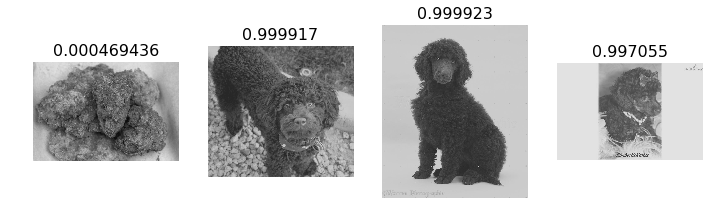

In [46]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

In [47]:
#2. A few incorrect labels at random
# NOthing to worry here with the Error because we dont have incorrect labels.
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])


IndexError: list index out of range

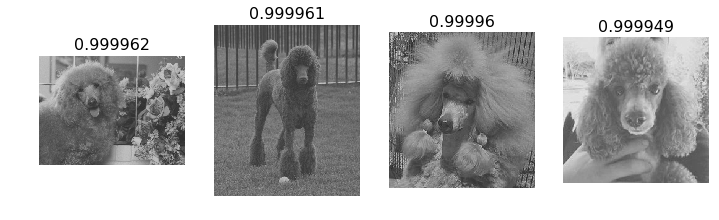

In [48]:

correct_dogs = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

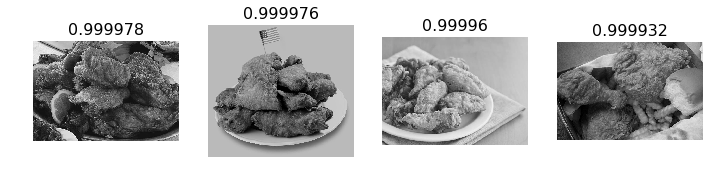

In [49]:
# as above, but fried chicken
correct_friedchicken = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_friedchicken = np.argsort(probs[correct_friedchicken])[:n_view]
plots_idx(correct_friedchicken[most_correct_friedchicken], 1-probs[correct_friedchicken][most_correct_friedchicken])

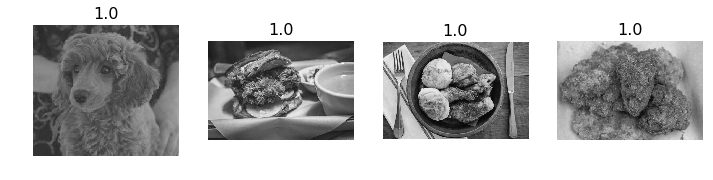

In [123]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [53]:
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[20  0]
 [ 0 20]]


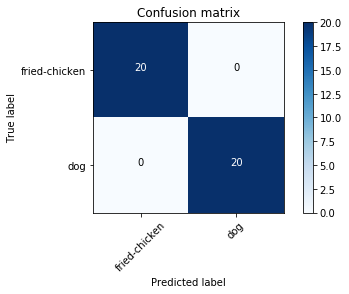

In [54]:
plot_confusion_matrix(cm, val_batches.class_indices)


### About activation functions

In [55]:
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])

In [56]:
# model.add(Dense(4096, activation='relu'))

# Modifying the model

## Retrain last layer's linear model

Since the original VGG16 network's last layer is Dense (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since the last layer had a softmax activation, which is an odd choice for an intermediate layer--and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing fried chicken and dogs? 

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [57]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [58]:
model.pop()
for layer in model.layers: layer.trainable=False

**Careful!** Now that we've modified the definition of *model*, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now we're ready to add our new final layer...

In [59]:
model.add(Dense(2, activation='softmax'))

In [60]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [61]:
??vgg.finetune

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [62]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

We'll define a simple function for fitting models, just to save a little typing...

In [91]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

...and now we can use it to train the last layer of our model!

(It runs quite slowly, since it still has to calculate all the previous layers in order to know what input to pass to the new final layer. We could precalculate the output of the penultimate layer, like we did for the final layer earlier - but since we're only likely to want one or two iterations, it's easier to follow this alternative approach.)

In [92]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
200/200 [==============================] - 360s - loss: 8.0075 - acc: 0.4950 - val_loss: 8.0590 - val_acc: 0.5000

In [94]:
model.save_weights(model_path+'finetune1.h5')

In [95]:
model.load_weights(model_path+'finetune1.h5')

In [96]:
model.evaluate(val_data, val_labels)

40/40 [==============================] - 18s    


[8.0590476989746094, 0.5]

We can look at the earlier prediction examples visualizations by redefining *probs* and *preds* and re-using our earlier code.

In [97]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

40/40 [==============================] - 20s     


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [98]:
cm = confusion_matrix(val_classes, preds)

[[20  0]
 [20  0]]


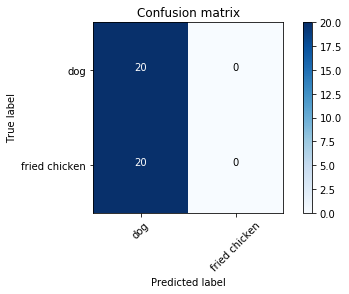

In [121]:
plot_confusion_matrix(cm, {'fried chicken':0, 'dog':1})

## Retraining more layers

Now that we've fine-tuned the new final layer, can we, and should we, fine-tune *all* the dense layers? The answer to both questions, it turns out, is: yes! Let's start with the "can we" question...

### An introduction to back-propagation

In [101]:
# sympy let's us do symbolic differentiation (and much more!) in python
import sympy as sp
# we have to define our variables
x = sp.var('x')
# then we can request the derivative or any expression of that variable
pow(2*x,2).diff()

8*x

### Training multiple layers in Keras

The code below will work on any model that contains dense layers; it's not just for this VGG model.


In [102]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

In [103]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
200/200 [==============================] - 405s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

In [104]:
model.save_weights(model_path+'finetune2.h5')

There's generally little room for improvement in training the convolutional layers, if you're using the model on natural images (as we are). However, there's no harm trying a few of the later conv layers, since it may give a slight improvement, and can't hurt (and we can always load the previous weights if the accuracy decreases).

In [105]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.001)

In [106]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
200/200 [==============================] - 447s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

In [119]:
model.save_weights(model_path+'finetune3.h5')


40/40 [==============================] - 16s    


[8.0590476989746094, 0.5]

In [120]:
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

AttributeError: 'Lambda' object has no attribute 'W'

You can always load the weights later and use the model to do whatever you need:

In [115]:
path


'data/small_data_set/'

In [118]:
model.load_weights(model_path+'finetune2.h5')
model.evaluate_generator(get_batches(path + 'valid', gen, False, batch_size*2), val_batches.n)

Found 40 images belonging to 3 classes.


ValueError: Error when checking model target: expected dense_7 to have shape (None, 2) but got array with shape (8, 3)